In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py

import sys
sys.path.append('./libs/')
sys.path.append('./mass/')

from functions import read_phobos, mass
from mesh_lib import propidx, setprop
from elemental_matrices import get_mass_matrix

import salvus.namespace as sn
from salvus.mesh import simple_mesh
from salvus.flow import api
from salvus.flow import simple_config, api

In [2]:
TENSOR_ORDER = int(os.environ.get("TENSOR_ORDER", 4))
NUM_RANKS = int(os.environ.get("NUM_RANKS", 100))
INITIAL_VALUES = True if int(os.environ.get("INITIAL_VALUES", 0)) == 1 else False
PRECONDITIONER = False if int(os.environ.get("PRECONDITIONER", 0)) == 1 else True
MASS_SCALING = False if int(os.environ.get("PRECONDITIONER", 0)) == 1 else True

MASS_SCALING=False

mflag = "w/" if MASS_SCALING else "w/o"
pflag = "w/" if PRECONDITIONER else "w/o"
iflag = "w/" if INITIAL_VALUES else "w/o"

VERBOSITY = int(os.environ.get("VERBOSITY", 1))
TOTAL_VOLUME = 1
print(
    f"Running 2D Cartesian Poisson problem on {NUM_RANKS} rank(s):\n"
    f"- order {TENSOR_ORDER},\n"
    f"- {mflag} mass scaling,\n"
    f"- {pflag} preconditioner,\n"
    f"- {iflag} initial values."
)

Running 2D Cartesian Poisson problem on 100 rank(s):
- order 4,
- w/o mass scaling,
- w/ preconditioner,
- w/o initial values.


In [3]:
main_period = 27.321661  #days, from wiki
ecc = 0.0549 #from wiki, check afterwards
semi_major = 384399.*10**3

G = 6.67430e-11
M1 = 1 / (4 * np.pi * G)
R_moon = 1737151. #from SPH expansion
V_moon = 2.1958*10**10 #from wiki
M_moon = 7.34630*10**22 #from Garcia et al., 2019
Earth_mass = 5.9722*10**24 #from https://en.wikipedia.org/wiki/Earth_mass
moon_rotp = 27.321661 #days from https://en.wikipedia.org/wiki/Moon


pois = 0.28

ecc = 0.0151
M_mars = 6.39*10**23

buffer = 0
epw = 0.1
mps = 3.
m1, RHOidx = meshing(outer_buf = 0)

In [4]:
file = open('./Interior models/ISSI_MOON_M3.nd', 'r')
data = file.readlines()
for i, row in enumerate(data):
    if row == 'mantle\n' or row=='outer-core\n':
        data.pop(i)
data = np.array([np.array(row.strip().split(' '), dtype = np.float64) for row in data])
intprop = {'z': data[:,0]*10**3, 'rho':data[:,3]*10**3, 'vp': data[:,1]*10**3, 'vs': data[:,2]*10**3}

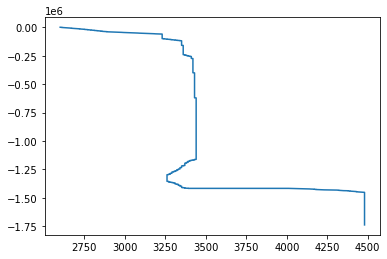

In [5]:
plt.plot(intprop['rho'], -intprop['z'])

In [6]:
def propidx(m, intprop, R_moon):
    radii = np.linalg.norm( m.get_element_nodes(), axis = 2)
    ll    = R_moon - intprop['z'] + 0.001
    ll = np.append(ll, 0.)
    ll = sorted(ll)
    RHOidx = list()
    if 'external' in m.elemental_fields.keys():
        for i in range(1, len(ll)):
            dx = abs(ll[i-1] - ll[i])
            RHOidx.append( np.where( abs(radii[(m.elemental_fields['external'] < 0.9)] \
                                         - ll[i-1] - dx/2.) <= dx/2.) ) 
    else:
        print('done 2')
        for i in range(1, len(ll)):
            dx = abs(ll[i-1] - ll[i]) 
            RHOidx.append( np.where( abs(radii - ll[i-1] - dx/2.) <= dx/2.) ) 
            
    return RHOidx

In [7]:
DTM=True
outer_buf = 20

mc = simple_mesh.Globe3D()
mc.basic.elements_per_wavelength = 0.1
mc.basic.model = "moon.bm"
mc.basic.min_period_in_seconds = 2.
mc.advanced.tensor_order = 4

if outer_buf > 0:
    mc.gravity_mesh.add_exterior_domain = True
    mc.gravity_mesh.nelem_buffer_outer = outer_buf
m = mc.create_mesh()
RHOidx = propidx(m, intprop, R_moon)

if DTM:
    lat,long,dem = read_phobos('./DTM/DTM.hdf5')

    eps = 0.01
    lat  = np.linspace(eps,     np.pi - eps, dem.shape[0])
    long = np.linspace(eps, 2 * np.pi - eps, dem.shape[1])

    m.add_dem_3D(lat, long, dem, mode='spherical_full', z0=0.0, zref=R_moon)
    m.apply_dem()

Outer radius (scaled to surface radius) :  887.791899806
number of elements in the exterior   :  57856


In [8]:
setprop(m, np.flip(intprop['rho']),   RHOidx, 'RHO')
setprop(m, np.flip(intprop['vp']),    RHOidx, 'VP')
setprop(m, np.flip(intprop['vs']),    RHOidx, 'VS')
m.elemental_fields['RHO'][m.elemental_fields['external']>0.5] = 0.

m.attach_field("fluid", np.zeros(m.nelem))

In [9]:
m.find_side_sets()
mass_matrix = get_mass_matrix(m)

volume = np.sum( mass_matrix )

model_mass = mass(m, mass_matrix)

print('model mass: ', model_mass, '\nmodel volume:', volume, '\nnelem: ', m.nelem )

model mass:  7.34464022685e+22 
model volume: 1.53650808905e+28 
nelem:  132608


In [10]:
rho = m.elemental_fields['RHO']
m.attach_field('RHS', rho)


m.attach_field('M0', 1.0 * np.ones_like(rho))
m.attach_field('M1', M1  * np.ones_like(rho))
m.attach_field("fluid", np.ones(m.nelem))

if 'RHO' in m.elemental_fields.keys():
    del m.elemental_fields['RHO']
m.write_h5('GRAV_RHS_Phobos.h5')

dirname = f'./Poisson'

w = sn.simple_config.simulation.Poisson(mesh=m)

w.domain.polynomial_order = m.shape_order
w.physics.poisson_equation.mass_matrix_scaling = MASS_SCALING

w.physics.poisson_equation.right_hand_side.filename = "GRAV_RHS_Phobos.h5"
w.physics.poisson_equation.right_hand_side.format = "hdf5"
w.physics.poisson_equation.right_hand_side.field = "RHS"

w.physics.poisson_equation.solution.fields = ['gradient-of-phi', 'solution', 'right-hand-side']
w.physics.poisson_equation.solution.filename = "grav_sol.h5"

boundaries = sn.simple_config.boundary.HomogeneousDirichlet(
    side_sets=["r2"]
)
w.add_boundary_conditions(boundaries)

#w.output.surface_data.fields = ['phi', 'gradient-of-phi']
#w.output.surface_data.sampling_interval_in_time_steps = 1
#w.output.surface_data.filename = 'solution_surf.h5'
#w.output.surface_data.side_sets = ['r1']
#w.output.surface_data.format = 'hdf5'

#
#w.output.volume_data.fields = ['phi', 'gradient-of-phi']
#w.output.volume_data.sampling_interval_in_time_steps = 1000
#w.output.volume_data.filename = 'solution_vol.h5'
#w.output.volume_data.format = 'hdf5'

w.solver.max_iterations = 1500
w.solver.absolute_tolerance = 0.0
w.solver.relative_tolerance = 1e-10
w.solver.preconditioner = PRECONDITIONER

w.validate()
# -

api.run(
    input_file=w,
    site_name="local",#
    output_folder= dirname,
    overwrite=True,
    ranks=10,
    verbosity=VERBOSITY,
    get_all = 1,
    wall_time_in_seconds = 3600.
)

Job `job_2104222342064054_1acaf4d417` running on `local` with 10 rank(s).
Site information:
  * Salvus version: 0.11.26-8-gca10e471
  * Floating point size: 64
-> Current Task: Setting up dynamic fields--------------------
The following exception happened while running the job:


Traceback (most recent call last):
  File "salvus/flow/api.py", line 541, in salvus.flow.api.run
  File "salvus/flow/sites/job.py", line 418, in salvus.flow.sites.job.Job.wait
KeyboardInterrupt


--------------------
Please hang on - cancelling job ...

💥  Cancelled job_2104222342064054_1acaf4d417@local

🗑  Deleting file   /Users/andrei/salvus_data/run_directory/job_2104222342064054_1acaf4d417/stdout ...
🗑  Deleting file   /Users/andrei/salvus_data/run_directory/job_2104222342064054_1acaf4d417/input/GRAV_RHS_Phobos.h5 ...
🗑  Deleting file   /Users/andrei/salvus_data/run_directory/job_2104222342064054_1acaf4d417/input/mesh.h5 ...
🗑  Deleting file   /Users/andrei/salvus_data/run_directory/job_2104222342064054_1acaf4d417/input/input.toml ...
🗑  Deleting folder /Users/andrei/salvus_data/run_directory/job_2104222342064054_1acaf4d417/input ...
🗑  Deleting file   /Users/andrei/salvus_data/run_directory/job_2104222342064054_1acaf4d417/stderr ...
🗑  Deleting file   /Users/andrei/salvus_data/run_directory/job_2104222342064054_1acaf4d417/output/progress.json ...
🗑  Deleting folder /Users/andrei/salvus_data/run_directory/job_2104222342064054_1acaf4d417/output ...
🗑  Deleting file   /Users/

KeyboardInterrupt: 

In [10]:
import h5py
dirname='./Poisson'
poisson_res = h5py.File(dirname + '/grav_sol.h5', 'r')
GRAV_X = poisson_res['MODEL']['data'][:,0,:]
GRAV_Y = poisson_res['MODEL']['data'][:,1,:]
GRAV_Z = poisson_res['MODEL']['data'][:,2,:]

In [11]:
if 'RHO' in m.elemental_fields.keys():
    rho = m.elemental_fields['RHO']
else:
    rho = m.elemental_fields['RHS']
m.attach_field('RHO', rho)
m.attach_field('GRAD_PHI_X', GRAV_X)
m.attach_field('GRAD_PHI_Y', GRAV_Y)
m.attach_field('GRAD_PHI_Z', GRAV_Z)
to_preserve = ['KAPPA', 'MU', 'RHO','fluid']
GRAD_PHI_MGN = np.linalg.norm([GRAV_X, GRAV_Y, GRAV_Z], axis = 0)
m.attach_field('GRAD_PHI_MAGN', GRAD_PHI_MGN)

In [12]:
mask = (m.elemental_fields['external']==0)
m2 = m.apply_element_mask(mask)
m2.find_surface()
m.attach_field("fluid", np.ones(m.nelem))
mass_matrix = get_mass_matrix(m2)

In [14]:
dirname = f'./elastostatic'
if not os.path.exists(dirname):
    os.mkdir(dirname)

for true_anomaly in [0., 3.14]:
    D_earth          = semi_major * (1 - ecc**2) / (1 + ecc * np.cos(true_anomaly))
    orbiter_mass     = Earth_mass
    orbiter_location = [D_earth, 0., 0.]

    GM = - G * orbiter_mass

    points =m2.points[m2.connectivity]
    diff_to_orbiter = points - orbiter_location

    dist3 = np.linalg.norm(diff_to_orbiter, axis=2) ** 3

    rho2 =m2.elemental_fields["RHO"]

    earth_attraction_X = rho2 * GM * (diff_to_orbiter[:,:,0] / dist3)
    earth_attraction_Y = rho2 * GM * (diff_to_orbiter[:,:,1] / dist3)
    earth_attraction_Z = rho2 * GM * (diff_to_orbiter[:,:,2] / dist3)

    self_rotation = False
    if self_rotation:    
        rot_period = moon_rotp
        om = 2 * np.pi / rot_period / 3600.
        om2 = om**2

        self_centf_x = rho * points[:,:,0] * om2
        self_centf_y = rho * points[:,:,1] * om2   
        m2.attach_field('scf_x', self_centf_x)
        m2.attach_field('scf_y', self_centf_y)


    v2_x       = GM / orbiter_location[0] * np.ones_like(earth_attraction_X)
    centrif_x = rho2 * v2_x / orbiter_location[0]

    if abs(orbiter_location[1]) > 1e-5:
        v2_y       = GM / orbiter_location[1] * np.ones_like(earth_attraction_X)
        centrif_y = rho2 * v2_y / diff_to_orbiter[:,:,1]
    else:
        centrif_y = np.zeros(centrif_x.shape)

    rhs_x = centrif_x + earth_attraction_X 
    rhs_y = centrif_y + earth_attraction_Y
    rhs_z = earth_attraction_Z

    if self_rotation:
        rhs_x = centrif_x + earth_attraction_X + self_centf_x
        rhs_y = centrif_y + earth_attraction_Y + self_centf_y
        rhs_z = earth_attraction_Z

    if true_anomaly < 1:
        drhs_x = rhs_x
        drhs_y = rhs_y
        drhs_z = rhs_z
    else:
        drhs_x -= rhs_x
        drhs_y -= rhs_y
        drhs_z -= rhs_z

weights = mass_matrix/np.sum(mass_matrix)
drhs_x -= np.sum( drhs_x * weights )
drhs_y -= np.sum( drhs_y * weights )
drhs_z -= np.sum( drhs_z * weights )

m2.attach_field('RHS_X', drhs_x/2.)
m2.attach_field('RHS_Y', drhs_y/2.)
m2.attach_field('RHS_Z', drhs_z/2.)

m2.attach_field('radius', np.linalg.norm(m2.points[m2.connectivity], axis=2))

if 'M0' in m2.elemental_fields.keys():
    del m2.elemental_fields['M0']
    del m2.elemental_fields['M1']
m2.write_h5(dirname + '/fullRHS_phobos.h5')

In [ ]:
w3 = sn.simple_config.simulation.Elastostatic(mesh=m2)

w3.domain.polynomial_order = m2.shape_order
w3.physics.elastostatic_equation.gravity = "cowling"

w3.physics.elastostatic_equation.right_hand_side.filename = dirname + "/fullRHS_phobos.h5"
w3.physics.elastostatic_equation.right_hand_side.format = "hdf5"
w3.physics.elastostatic_equation.right_hand_side.fields = ['RHS_X','RHS_Y','RHS_Z']

w3.physics.elastostatic_equation.mass_matrix_scaling = MASS_SCALING

w3.physics.elastostatic_equation.solution.filename = f"deformation.h5"
w3.physics.elastostatic_equation.solution.fields = ['solution', 'residuals']


w3.solver.max_iterations = 1500
w3.solver.absolute_tolerance = 0.0
w3.solver.relative_tolerance = 9e-6
w3.solver.preconditioner = PRECONDITIONER

w3.output.surface_data.fields = ["displacement"]
w3.output.surface_data.filename = f"surface_deformation.h5"
w3.output.surface_data.format = "hdf5"
w3.output.surface_data.sampling_interval_in_time_steps = 1
w3.output.surface_data.side_sets = ["r1"]

w3.validate()

api.run(
    input_file=w3,
    site_name="local",
    output_folder=dirname,
    overwrite=True,
    ranks=10,
    verbosity=VERBOSITY,
    wall_time_in_seconds=3600.,
    get_all = True,
)

Job `job_2104231648626611_36e54ec3a3` running on `local` with 10 rank(s).
Site information:
  * Salvus version: 0.11.26-8-gca10e471
  * Floating point size: 64


Solving linear system:   0%|          | 0/1500 [00:00<?, ?it/s]

In [ ]:
file = h5py.File(dirname + '/deformation.h5', 'r')
DEFORM_X = file['MODEL']['data'][:,0,:]
DEFORM_Y = file['MODEL']['data'][:,2,:]
DEFORM_Z = file['MODEL']['data'][:,4,:]
file.close()

deform_mag = np.linalg.norm([DEFORM_X, DEFORM_Y, DEFORM_Z], axis=0)
m2.attach_field('deform_mag', deform_mag)
m2.attach_field('radius', np.linalg.norm(m.points[m2.connectivity], axis=2)-R_moon)
m2.write_h5(dirname + '/defres.h5')